# PyTorch ANN on Individual Timepoints

This notebook uses an artificial neural network in Pytorch to classify individual timepoints of activity rounds

__INPUT: .csv files containing individual timepoints sampled at .25 seconds (plain_data.csv)__

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics as metrics
import random
import torch
from torch import nn
import torch.nn.functional as F
from keras.utils import to_categorical
from keras.utils import np_utils
import random
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
random.seed(999)

## Read in data

This dataset contains the individual timepoints of the sensors. As you can see, there is an imbalance of activity classes.

In [2]:
df  = pd.read_csv('plain_data.csv')
df['Activity'].value_counts()

Activity    127200
Baseline    101760
DB           25440
Type         25440
Name: Activity, dtype: int64

Here, we attempt to balance the classes so that model performance is not biased towards the more prevalent classes. Unfortunately, even after many different attempts to balance classes by undersampling by various amounts, there was not one undersampling ratio that was clearly better than another.

However, balancing the classes like this gives better results than leaving the classes as they originally stand, so it is still important to balance.

In [3]:
df_a = df[df['Activity'] == 'Activity'].sample(35440)
df_b = df[df['Activity'] == 'Baseline'].sample(45440)
df_t = df[df['Activity'] == 'Type']
df_d = df[df['Activity'] == 'DB']
df = pd.concat([df_a, df_b, df_t, df_d])

### Make train/val/test split

The validation and testing scheme for this notebook is to take a random sample of 45 subjects for the training set, validate on 5 subjects during training to assess overfitting during training epochs, and then to test on 6 subjects.

Cross validation was not performed, but may be implemented in a future edition of this notebook.

In [4]:
#make a list of ID's in a random order
ID_list = list(df['Subject_ID'].unique())
random.shuffle(ID_list)

#initialize dataframes the splits go into
train = pd.DataFrame()
val = pd.DataFrame()
test = pd.DataFrame()

#decide sizes of splits by indexing into randomly ordered ID list. index != ID.
#splitting on ID allows us to generalize better if we were to have another subject's data
train = df[df['Subject_ID'].isin(ID_list[:45])]
val = df[df['Subject_ID'].isin(ID_list[45:50])]
test = df[df['Subject_ID'].isin(ID_list[50:])]

### Seperate data from labels

In [5]:
#put the sensors that you want to use in here. see comment at bottom of cell for full list and legend
activity_list = ['ACC1', 'ACC2', 'ACC3','TEMP', 'EDA', 'HR', 'BVP', 'Magnitude',]
num_sensors = len(activity_list)

#splitting the splits into data and labels
#first, isolate the data
X_train = train[activity_list] 
X_val = val[activity_list]
X_test = test[activity_list]


#then, isolate the labels
y_train = train['Activity']
y_val = val['Activity']
y_test = test['Activity']


#the data (X) is used to predict the labels (y) in each split (train, val, test)

#what the sensor names correspond to
#['ACC1', 'ACC2', 'ACC3','TEMP', 'EDA', 'HR', 'BVP', 'Magnitude',] 
#Accelerometry Axes, Body Temperature, Electrodermal Activity, Heart Rate, Blood Volume Pulse, Magnitude of Axes

#this model uses all of the sensor data. please see the User Guide for a comparison between using all of...
#...the features, just the ACC and Magnitude, and just the Physiological sensor data

### Scale data

In [6]:
#ignore pink box of suggestions when this runs

#scales the data to have a min of 0 and a max of 1

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
for activity in activity_list:
    #scale train data
    temp_x_train = X_train[activity].to_numpy() 
    X_train[activity] = scaler.fit_transform(temp_x_train.reshape(-1, 1))
    
    #scale validation data
    temp_x_val = X_val[activity].to_numpy()
    X_val[activity] = scaler.fit_transform(temp_x_val.reshape(-1, 1))
    
    #scale test data
    temp_x_test = X_test[activity].to_numpy()
    X_test[activity] = scaler.fit_transform(temp_x_test.reshape(-1, 1))
    
y_train #what it turns into

/Users/noahlanier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/noahlanier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/noahlanier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

254097    Activity
19705     Activity
94279     Activity
275647    Activity
89120     Activity
            ...   
278395          DB
278396          DB
278397          DB
278398          DB
278399          DB
Name: Activity, Length: 106730, dtype: object

### Encode labels

In [7]:
#assigns the labels, which are currently strings, to numerical values, the form required for model interpretation

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)


np.unique(y_train) #here's what it turns into

array([0, 1, 2, 3])

### Initializing the model

The model is a fully connected (dense) feedforward neural network, or an artificial neural network. This code initializes the model, it does not run it.

In [8]:
# define the network class
class DenseHAR(nn.Module):
    
    def __init__(self):
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.fc1 = nn.Linear(num_sensors, 16) #num_sensors is a variable defined where the activity list is
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, 32)  
        self.fc5 = nn.Linear(32,4)
        
    def forward(self, x):
        # define forward pass
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# instantiate the model
model = DenseHAR()

# print model architecture
print(model)

DenseHAR(
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=4, bias=True)
)


### Further format data and check what we did

In [9]:
#needs to be like this to input to DataLoader later
X_train = X_train.values
X_test = X_test.values
X_val = X_val.values

In [10]:
print(X_train.shape, y_train.shape) #verify that amount of datapoints matches the amount of labels 

(106730, 8) (106730,)


In [11]:
#here's what a datapoint and label pair looks like
#the array as a whole corresponds to the single label

print(X_train[0])
print()
print(y_train[0])


[-0.22689076 -0.13389356  0.34728033  0.49723145 -0.99352715 -0.48789078
 -0.05434525 -0.48792587]

0


### Make Dataloader

The DataLoader is a tool specific to Pytorch that allows one to seemlessly feed in their data to their model.

In [12]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
from torch.autograd import Variable

#a dataloader sets up our data to be input into a pytorch model

def make_loader(X_dataset, y_dataset, batch_size, shuffle): #function to make a dataloader
    
    class LOAD_UP(Dataset): #turns function input dataset into an object the DataLoader constructor can understand
                            
        def __init__(self):
            self.x = torch.from_numpy(X_dataset[:, 0:])
            self.y = torch.from_numpy(y_dataset)
            self.n_samples = X_dataset.shape[0]
    
        def __getitem__(self,index):
            return self.x[index], self.y[index]
    
        def __len__(self):
            return self.n_samples

    dataset = LOAD_UP() #makes the DataLoader object
    return DataLoader(dataset = dataset, 
                      shuffle = shuffle, #if you want inputs to be in a random order. we want this.
                      batch_size = batch_size, #how many the dataloader feeds in at a time
                      num_workers = 4)


train_loader = make_loader(X_train, y_train, 40, True) #making loaders for each dataset that will go into the model
test_loader = make_loader(X_test, y_test, len(X_test), True) #batch size for the following is the same as the length because we want everything fed in at once
val_loader = make_loader(X_val, y_val, len(X_val), True)

### Training and validating

Running the model through more than one epoch immediately results in overfitting where the training accuracy increases and the validation accuracy decreases, so we only run it for one epoch. The TensorFlow model does not do this, yet has the same architecture, which is curious. This is something that ought to be addressed if there is a future iteration of this notebook.

In [13]:
# Loss
criterion = nn.CrossEntropyLoss()

# Optimizer
opt = torch.optim.Adam(model.parameters(), lr=0.001)

#initialize variables
train_total = 0 
train_correct = 0
train_acc = 0
running_loss = 0

for epoch in range(1): #how many times we go through the data
    
    for v, val_data in enumerate(val_loader):
        
        for i, data in enumerate(train_loader):
            # unpack data in dataloader to the inputs and labels
            inputs, labels = data
        
            # variable
            inputs, labels = Variable(inputs), Variable(labels)
       
            # Forward pass: Compute predic y by passing x through model
            y_pred = model(inputs.float())
        
            # Loss
            loss = criterion(y_pred, labels)
            #print(epoch, i, loss.data[0])
        
            # Zero the gradients, backward pass, update weights
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Compute Loss and Accuracy      
            running_loss += loss.item()
            
            #get the actual prediction
            scores, prediction = torch.max(y_pred.data, 1)
            
            
            #add the amount got right in the batch to the total got right for the epoch
            train_correct += int(sum(prediction == labels))
            
            
        train_acc = train_correct/len(y_train) #calcualte training accuracy: amount right/amount of labels
        
        #using the validation dataloader, first unpacking the data
        val_inputs, val_labels = val_data
        
        #variable?
        val_inputs, val_labels = Variable(val_inputs), Variable(val_labels)
        
        #use the model to get 
        y_val_pred = model(val_inputs.float())
        
        #calculate
        val_loss = criterion(y_val_pred, val_labels) #y_val_pred has 4 values, one for each potential class
        val_scores, val_prediction = torch.max(y_val_pred.data, 1) #taking softmax of the model's output to get most likely class
        val_acc = int(sum(val_prediction == val_labels))/len(val_labels) #how many predictions match up with labels divided by total number of labels

    # Print training and validation accuracy per epoch 
    print(f'Epoch: {epoch+1}\n training loss: {running_loss/len(train_loader):.5f}, training acc: {train_acc}')
    print(f'validation loss: {val_loss:.5f}, validation acc: {val_acc}')
    print(val_prediction)
    train_total = 0
    train_correct = 0
    train_acc = 0
    running_loss = 0

print('Finished Traning')

Epoch: 1
 training loss: 0.80358, training acc: 0.6593179049939099
validation loss: 0.93259, validation acc: 0.6140505115089514
tensor([1, 2, 3,  ..., 1, 1, 0])
Finished Traning


### Demonstration of output of model before softmax

In [14]:
#for educational purposes

def check_validation(index): #shows how the biggest value position in the model output usually corresponds to what label the data actually has
    print(y_val_pred[index])
    print(val_labels[index])
check_validation(3) #change this around to explore what the model did with individual validation datapoints

#see how the prediction (1) matches up with the index of the largest value of the tensor

tensor([-1.1306,  0.6093, -1.1616, -1.3673], grad_fn=<SelectBackward>)
tensor(0)


### Validation Confusion Matrix

Text(0.5, 1.0, 'Duke Data Rolled ANN - Confusion Matrix')

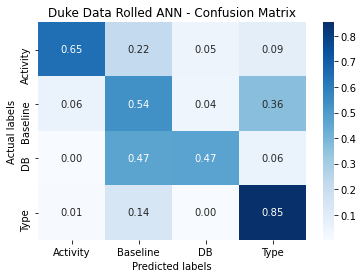

In [15]:
cm = sklearn.metrics.confusion_matrix(val_labels, val_prediction)
cm= cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]

ax = plt.subplot()
sns.heatmap(cm, annot = True, fmt = '.2f',cmap = 'Blues', xticklabels = le.classes_, yticklabels = le.classes_)
ax.set_xlabel("Predicted labels")
ax.set_ylabel('Actual labels')
plt.title('Duke Data Rolled ANN - Confusion Matrix')


### Run model on the test set

In [16]:
test_total = 0
test_correct = 0
test_acc = []
for i, data in enumerate(test_loader):
        # inputs
        test_inputs, test_labels = data
        
        # variable
        test_inputs, test_labels = Variable(test_inputs), Variable(test_labels)
       
        # Forward pass: predict labels by passing inputs through model for test set
        y_pred = model(test_inputs.float())
        
        test_scores, test_prediction = torch.max(y_pred.data, 1)
        
        test_total += test_labels.size(0)
        test_correct += int(sum(test_prediction == test_labels))
        test_acc = test_correct/test_total

### Test Accuracy and Confusion Matrix

In [17]:
test_acc

0.6198274484741971

Text(0.5, 1.0, 'Duke Data Rolled ANN - Confusion Matrix')

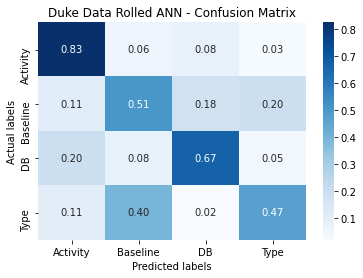

In [18]:
cm = metrics.confusion_matrix(test_labels, test_prediction.numpy())
cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]


ax = plt.subplot()
sns.heatmap(cm, annot = True, fmt = '.2f',cmap = 'Blues', xticklabels = le.classes_, yticklabels = le.classes_)
ax.set_xlabel("Predicted labels")
ax.set_ylabel('Actual labels')
plt.title('Duke Data Rolled ANN - Confusion Matrix')

## General Notes

These results vary between different runs. If you were to have the data and run this notebook multiple times, you would get different metrics each time. For an accurate depiction of what a typical model does, one would have to run the model many times and get an average. We do not do this for this model, but do have results for what the TensorFlow model has.

The TensorFlow model results are likely more indicative of the metrics that come from classifying individual timepoints because that model's training does not overfit after 1 epoch.

We still decided to include the Pytorch model in this module of the DBDP because there are a dearth of Pytorch resources available and it 